In [1]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline  

C:\Users\abc33\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


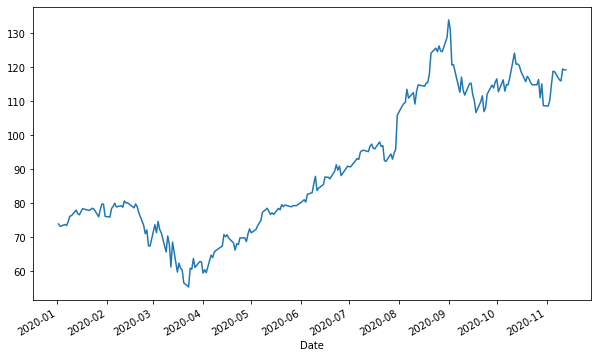

In [2]:
def getYahooData(ticker):
    #import pandas_datareader.data as web
    start = dt.datetime(2020,1,1)
    end =  dt.datetime(2020,11,14) #dt.datetime.now()

    df_stock = web.DataReader(ticker, 'yahoo', start, end)
    return df_stock

stock = getYahooData('AAPL')
stock['Adj Close'].plot(figsize=(10,6))

In [3]:
stock['return']=stock['Adj Close'].pct_change()
stock['PnL']=stock['return'].cumsum()
stock['max']=np.maximum.accumulate(stock['Adj Close'])
del stock['High'],stock['Low'],stock['Open'],stock['Close'],stock['Volume']
stock.head()

,Adj Close,return,PnL,max
Date,,,,
2020-01-02,73.840042,NaN,NaN,73.840042
2020-01-03,73.122154,-0.009722,-0.009722,73.840042
2020-01-06,73.704819,0.007968,-0.001754,73.840042
2020-01-07,73.358185,-0.004703,-0.006457,73.840042
2020-01-08,74.538239,0.016086,0.009629,74.538239


In [4]:
# calculate max drawdown, depth, and recovery time
stock['mdd'] = 0
stock['mdepth'] = 0
stock['recovery time'] = 0
peak = -1 # peak index
peak2 = -1 # peak2 index, recover = peak - peak2
for i in range(0, len(stock)):
    if stock['max'].iloc[i] == stock['Adj Close'].iloc[i]:
        if peak == -1 and peak2 == -1:
            peak = peak2 = i
        else:
            peak = i
        
        if stock['mdd'].iloc[i-1] > 0:
            stock['mdepth'].iloc[i-1] = stock['mdd'].iloc[i-1]
            stock['recovery time'].iloc[i] = peak - peak2
        peak2 = peak
        
    else:
        res = stock['max'].iloc[i] - stock['Adj Close'].iloc[i]
        if res > stock['mdd'].iloc[i-1]:
            stock['mdd'].iloc[i] = res 
        else:
            stock['mdd'].iloc[i] = stock['mdd'].iloc[i-1]
    

C:\Users\abc33\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
stock.to_csv('result.csv')

In [6]:
stock

,Adj Close,return,PnL,max,mdd,mdepth,recovery time
Date,,,,,,,
2020-01-02,73.840042,NaN,NaN,73.840042,0.000000,0.000000,0
2020-01-03,73.122154,-0.009722,-0.009722,73.840042,0.717888,0.000000,0
2020-01-06,73.704819,0.007968,-0.001754,73.840042,0.717888,0.000000,0
2020-01-07,73.358185,-0.004703,-0.006457,73.840042,0.717888,0.717888,0
2020-01-08,74.538239,0.016086,0.009629,74.538239,0.000000,0.000000,4
...,...,...,...,...,...,...,...
2020-11-09,116.320000,-0.019968,0.559028,133.948898,27.292908,0.000000,0
2020-11-10,115.970001,-0.003009,0.556019,133.948898,27.292908,0.000000,0
2020-11-11,119.489998,0.030353,0.586371,133.948898,27.292908,0.000000,0


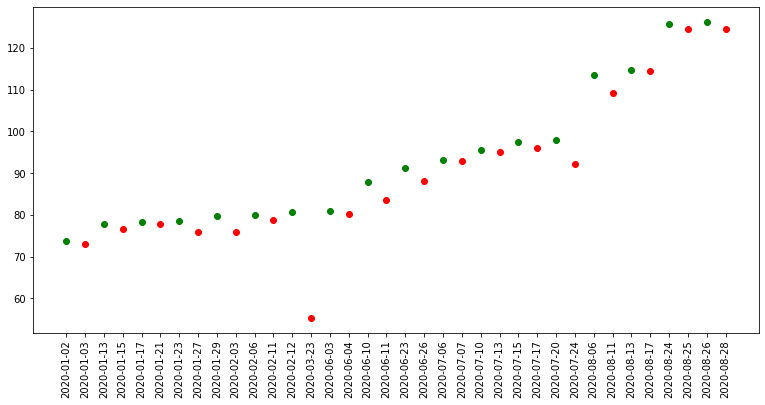

In [7]:
#plot mdd dot graph  
time_of_drawdown = []
plt.figure(figsize=(13,6))
plt.xticks(rotation=90)
for i in range(1,len(stock)):
    if(stock['mdepth'].iloc[i] != 0):
        pos = str(stock[stock['mdd'] == stock['mdepth'].iloc[i]].index.tolist()[0]).split()[0]
        pos_data = str(stock[stock['Adj Close'] == stock.loc[pos,'max']].index.tolist()[0]).split()[0]
        time_of_drawdown.append('({}'.format(pos_data) + ',' + '{})'.format(pos))
        plt.plot(pos_data,stock.loc[pos_data,'Adj Close'],'o',color = 'green')
        plt.plot(pos,stock.loc[pos,'Adj Close'],'o',color = 'red')

In [8]:
#plot mdd with adjust close price  
time_of_drawdown = []
df = pd.DataFrame(columns=['Date','Adj Close'])
for i in range(1,len(stock)):
    if(stock['mdepth'].iloc[i] != 0):
        pos = str(stock[stock['mdd'] == stock['mdepth'].iloc[i]].index.tolist()[0]).split()[0]
        pos_data = str(stock[stock['Adj Close'] == stock.loc[pos,'max']].index.tolist()[0]).split()[0]
        
        time_of_drawdown.append('({}'.format(pos_data) + ',' + '{})'.format(pos))
        df = df.append({'Date':pos_data,'Adj Close':stock.loc[pos_data,'Adj Close']},ignore_index=True)
        df = df.append({'Date':pos,'Adj Close':stock.loc[pos,'Adj Close']},ignore_index=True)
df['Date']=pd.to_datetime(df['Date'])
df = df.set_index('Date',drop=True)

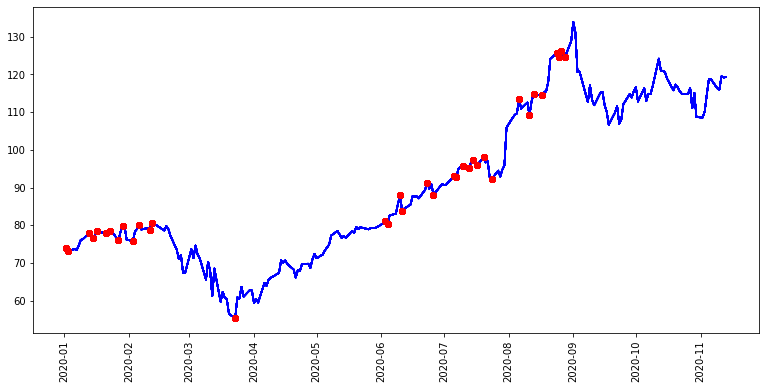

In [9]:
plt.figure(figsize=(13,6))
plt.xticks(rotation=90)
for i in range(len(df)):
    plt.plot(stock['Adj Close'],color='blue')
    plt.plot(df.index,df,'o',color='red')

In [10]:
time_of_drawdown

['(2020-01-02,2020-01-03)',
 '(2020-01-13,2020-01-15)',
 '(2020-01-17,2020-01-21)',
 '(2020-01-23,2020-01-27)',
 '(2020-01-29,2020-02-03)',
 '(2020-02-06,2020-02-11)',
 '(2020-02-12,2020-03-23)',
 '(2020-06-03,2020-06-04)',
 '(2020-06-10,2020-06-11)',
 '(2020-06-23,2020-06-26)',
 '(2020-07-06,2020-07-07)',
 '(2020-07-10,2020-07-13)',
 '(2020-07-15,2020-07-17)',
 '(2020-07-20,2020-07-24)',
 '(2020-08-06,2020-08-11)',
 '(2020-08-13,2020-08-17)',
 '(2020-08-24,2020-08-25)',
 '(2020-08-26,2020-08-28)']